In [1]:
import os
import sys
import pdb
import numpy as np
import scipy.interpolate
import scipy.io

import importlib
import port
importlib.reload(port)

import matplotlib.pyplot as plt


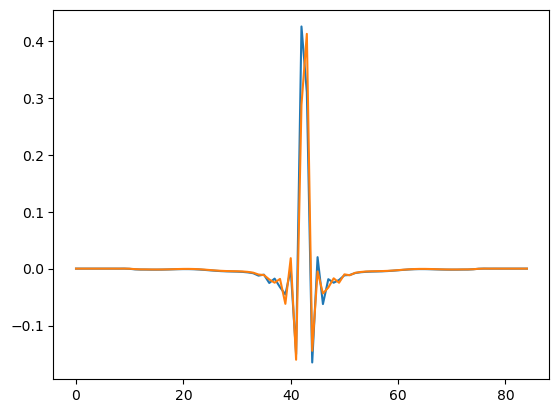

In [2]:
import port
importlib.reload(port)

sdelay = np.array([0.411119294090895, 0.600165773186745])
gain = np.array([
    [0.013462743344629,0.056313514709473,0.137448031335961,0.278500976009402,0.483982307179293,0.664832635991501],
    [0.008750783174009,0.042235136032104,0.112707385695488,0.245080858888274,0.450103545676742,0.638239330551840],
])
freq = np.array([0.002834467120181,0.005668934240363,0.011337868480726,0.022675736961451,0.045351473922902,0.090702947845805])
sr = 44100
ctap = 11
ctap2 = 33
hout = port.shapedfilter_hrtf(sdelay, freq, gain, sr, ctap, ctap2)
fig, ax = plt.subplots()
ax.plot(hout.T)
plt.show()


In [44]:
import port
import importlib
importlib.reload(port)

h_out, lead_zeros = port.room_impulse_hrtf(jitter=False, meas_sym=1)
print('END')


END


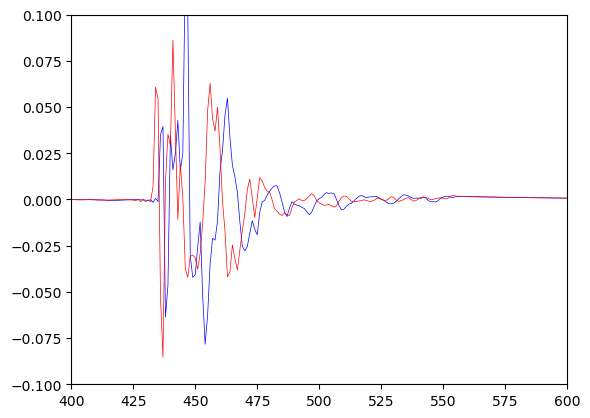

In [46]:
fig, ax = plt.subplots()
ax.plot(h_out[:, 0], 'b', lw=0.5)
ax.plot(h_out[:, 1], 'r', lw=0.5)
ax.set_xlim([400, 600])
ax.set_ylim([-0.1, 0.1])
plt.show()


In [14]:
fn = 'HRTFs/elev0/H0e140a.wav'
sr, y = scipy.io.wavfile.read(fn)
print(sr)

import soundfile as sf
y, sr = sf.read(fn)
print(y.max())


44100
0.41558837890625
